# Fit halo mass to shear profile: 2. object-oriented modeling

_the LSST-DESC CLMM team_


This notebooks performs the same set of operations as `Example2_Fit_halo_Mass_to_Shear_Catalog.ipynb`, but uses instead the object-oriented interface to build the model. Here the NumCosmo theory backend is used but you may try the `CCL` or `cluster_toolkit` backend instead. For that, change the line `os.environ['CLMM_MODELING_BACKEND'] = 'nc'` to :
 - `os.environ['CLMM_MODELING_BACKEND'] = 'ccl'` - for `CCL`
 - `os.environ['CLMM_MODELING_BACKEND'] = 'ct'` - for `cluster_toolkit`

## Setup

First, we import some standard packages.

In [119]:
import os
os.environ['CLMM_MODELING_BACKEND'] = 'nc' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)
import clmm
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from clmm.support.sampler import fitters

clmm.__version__

'1.1.0'

Next, we import `clmm`'s core modules.

In [120]:
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology 

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.

In [121]:
from clmm.support import mock_data as mock

## Making mock data

For reproducibility:

To create mock data, we need to define a true cosmology, which is currently done with [`astropy`'s cosmology library](http://docs.astropy.org/en/stable/cosmology/index.html).

In [122]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

We now set some parameters for a mock galaxy cluster.

In [123]:
cosmo = mock_cosmo
cluster_m = 1.e15 # M200,m [Msun]
cluster_z = 0.3
concentration = 4
ngals = 15000
cluster_ra = 0.0
cluster_dec = 0.0
# First define a CLMM theory object to use with the NC or CCL backend
moo = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(mock_cosmo)
moo.set_concentration (4)

Then we use the `mock_data` support module to generate 3 galaxy catalogs:
- `ideal_data`: all background galaxies at the same redshift.
- `ideal_data_z`: galaxies distributed according to the Chang et al. (2013) redshift distribution.
- `noisy_data_z`: `ideal_data_z` + photoz errors + shape noise

In [124]:
noisy_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo,'chang13', 
                                            shapenoise=0.07, 
                                            photoz_sigma_unscaled=0.05, ngals=ngals)
cluster_id = "CL_noisy_z"
cl3 = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, noisy_data_z)
theta2, g_t3, g_x3 = cl3.compute_tangential_and_cross_components(geometry="flat", is_deltasigma = True, cosmo = mock_cosmo)

bin_edges = da.make_bins(0.1, 8, 15, method='evenlog10width')

profile3 = cl3.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo)

def ds_profile_model(r, logm, c, a):

    moo.set_mass (10.**logm)
    gt_model = a**2*moo.eval_excess_surface_density (a*r, cluster_z)
    return gt_model

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


In [139]:
def log_probability(theta):
    logm, c, a = theta
    if a < 0.: return np.inf
    if a > 3.: return np.inf
    if c < 0.: return np.inf
    if c > 200: return np.inf
    model = ds_profile_model(profile3['radius_min'], logm, c, a)
    return -.5*np.sum((model-profile3['gt'])**2/profile3['gt_err']**2)

In [172]:
import emcee
import corner
pos = [15, 1, 1] + 1e-4 * np.random.randn(100, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 1000, progress=True);

  3%|▎         | 34/1000 [00:01<00:51, 18.90it/s]/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:14<00:00, 68.73it/s]


In [177]:
flat_samples = sampler.get_chain(discard=10, thin=1, flat=True)

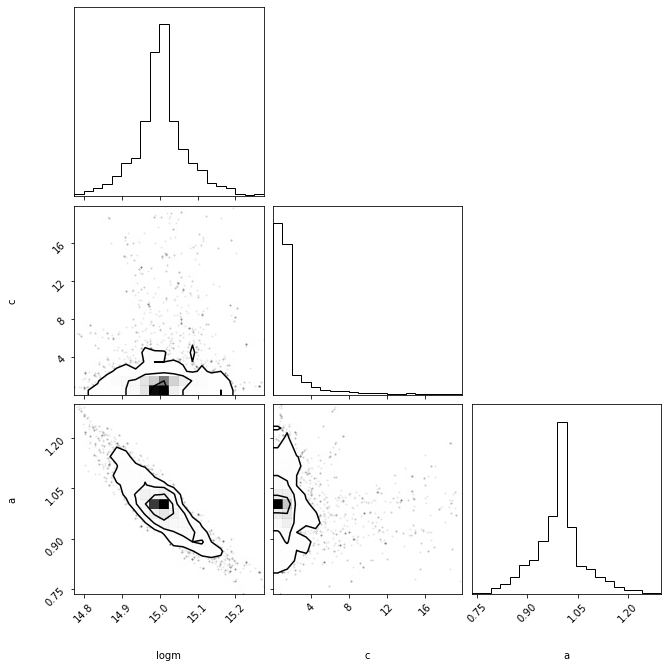

In [178]:
import corner
fig, ax = plt.subplots(3,3, figsize = (10,10))
mask = flat_samples[:,1] > 0
mask = mask*(flat_samples[:,1] < 20)
mask = mask*(flat_samples[:,2] > 0)
mask = mask*(flat_samples[:,2] < 3)
labels = ['logm', 'c', 'a']
fig = corner.corner(
    flat_samples[mask], fig = fig,labels = labels);

In [12]:
noisy_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo,'chang13', 
                                            shapenoise=0.07, 
                                            photoz_sigma_unscaled=0.05, ngals=ngals)

cluster_id = "CL_noisy_z"
cl3 = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, noisy_data_z)

theta2, g_t3, g_x3 = cl3.compute_tangential_and_cross_components(geometry="flat", is_deltasigma = True, cosmo = mock_cosmo)

bin_edges = da.make_bins(0.7, 8, 15, method='evenlog10width')

profile3 = cl3.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo)

def ds_profile_model(r, logm, c, a):

    moo.set_mass (10.**logm)
    gt_model = a**2*moo.eval_excess_surface_density (a*r, cluster_z)
    return gt_model

popt1,pcov1 = fitters['curve_fit'](lambda r, logm:ds_profile_model(r, logm), 
                    profile3['radius'], 
                    profile3['gt'], 
                    profile3['gt_err'], bounds=[13.,17.])

fig, ax = plt.subplots(figsize=(10, 7))
plt.loglog()
import matplotlib
plt.errorbar(profile3['radius'], profile3['gt'], yerr=profile3['gt_err'], marker='o', fmt = ' ',  c='k',
                   label = r'$\widehat{\Delta\Sigma}$')
r = np.linspace(.7, 8, 100)
plt.loglog(r, ds_profile_model(r, popt1[0]), label = 'best fit', linewidth = 2)
plt.xlabel('R [Mpc]', fontsize = 20)
plt.ylabel(r'$\Delta\Sigma$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 20)
plt.legend(fontsize = 20)
ax.set_xticks(np.arange(6)+1)
plt.ylim(7e12, 2e14)
plt.xlim(.6, 9)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.tick_params(axis='both', which = 'major', labelsize= 20)
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/DS_mock.png', bbox_inches='tight', dpi=300)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


TypeError: ds_profile_model() missing 2 required positional arguments: 'c' and 'a'